# Sentiment Analysis
## This code is to predict whether a movie review is positive or negative based on the text of the review. 
### This was my capstone project for the Advanced Machine Learning class in the Machine Learning Certificate Program at the University of Washington - Professional and Continuing Education 

Spencer K'Burg

September 2019

Much of the word embeddings code is from code that Stuart Owen Axelbrooke shared in his "A Brief History of Sentiment Classifiers" presentation to the NLSEA Meetup on 4/8/2019 
https://www.meetup.com/PSPPython/events/259884581/

* The reviews.csv file was too large to easily upload to Github. 
* crawl-300d-2M.vec is 4.5 GB. It should be easy to find and download online. 

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression

from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors

from typing import Sequence

%matplotlib inline 

In [2]:
pd.set_option('max_colwidth', 150)

In [3]:
data = pd.read_csv('Reviews.csv')

In [4]:
data.head(20)

,review,sentiment
0,"My family and I normally do not watch local movies for the simple reason that they are poorly made, they lack the depth, and just not worth our ti...",1
1,"Believe it or not, this was at one time the worst movie I had ever seen. Since that time, I have seen many more movies that are worse (how is it p...",0
2,"After some internet surfing, I found the ""Homefront"" series on DVD at ioffer.com. Before anyone gets excited, the DVD set I received was burned by...",0
3,"One of the most unheralded great works of animation. Though it makes the most sophisticated use of the ""cut-out"" method of animation (a la ""South ...",1
4,"It was the Sixties, and anyone with long hair and a hip, distant attitude could get money to make a movie. That's how Michael Sarne, director of t...",0
5,"For my humanities quarter project for school, i chose to do human trafficking. After some research on the internet, i found this DVD and ordered i...",1
6,"Arguebly Al Pacino's best role. He plays Tony Montana, A small time hood from Cuba turned into a rich and powerful crime lord in Miami, and he doe...",1
7,"Being a big fan of Stanley Kubrick's Clockwork Orange there was of course ""no question about it"" that I had to see this one. However I put it off ...",1
8,"I reached the end of this and I was almost shouting ""No, no, no, NO! It cannot end here! There are too many unanswered questions! The engagement o...",1
9,There is no doubt that Halloween is by far one of the best films ever not only in its genre but also outside.I love the films creepy atmosphere li...,1


In [5]:
data.groupby('sentiment').count()

,review
sentiment,
0,25000
1,25000


This is a balanced dataset, so an accuracy of 50% is the baseline. 

In [6]:
x = data.iloc[:, 0]
y = data.iloc[:, 1]

Split the data into train and test datasets.

In [7]:
train_x, test_x, train_y, test_y = train_test_split(x, y, random_state = 0)

Use word embeddings to get some meaning from the words in a review. 

In [8]:
word_embeddings = Word2VecKeyedVectors.load_word2vec_format('crawl-300d-2M.vec', limit=500000)

Here's just a simple example of how word embeddings can be used (as well as a quick check).

In [9]:
# calculate: (king - man) + woman = ?
result = word_embeddings.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

[('queen', 0.738545835018158)]


tokenize splits the text strings into separate words. 
vectorize applies the word embeddings.

In [10]:
def tokenize(text: str) -> Sequence[str]:
    return re.findall('\w+|\S', text)

def vectorize(text: str) -> np.ndarray:
    vectors = []
    for token in tokenize(text):
        try:
            vectors.append(word_embeddings.get_vector(token))
        except:
            pass
    if len(vectors) == 0:
        return np.zeros(word_embeddings.vectors.shape[1])
    return np.sum(vectors, axis=0)

WordEmbeddingClassifier fits, predicts if a review is possitive negative, and a probability that the review is positive.

In [11]:
class WordEmbeddingClassifier():
    def __init__(self):
        self.model = LogisticRegression()

    def fit(self, x: Sequence[str], y: Sequence[int]):
        x_vecs = np.vstack([vectorize(text) for text in x])
        self.model.fit(x_vecs, y)
        
    def predict(self, x: Sequence[str]) -> Sequence[int]:
        x_vecs = [vectorize(text) for text in x]
        return self.model.predict(x_vecs)
    
    def predict_proba(self, x: Sequence[str]) -> Sequence[int]:
        x_vecs = [vectorize(text) for text in x]
        return self.model.predict_proba(x_vecs)
    

In [12]:
clf = WordEmbeddingClassifier()

In [13]:
clf.fit(train_x, train_y)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [14]:
pred_y = clf.predict(test_x)

In [15]:
pred_proba_y = clf.predict_proba(test_x)

In [16]:
accuracy_score(test_y, pred_y)

0.8672

In [17]:
pred_proba_y = pred_proba_y[:,1]

In [18]:
roc_auc = roc_auc_score(test_y, pred_proba_y)

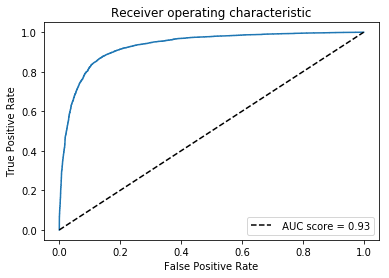

In [19]:
fpr, tpr, thresholds = roc_curve(test_y, pred_proba_y)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'k--', label=' AUC score = %0.2f' %roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')

In [20]:
confusion_matrix(test_y, pred_y)

array([[5253,  850],
       [ 810, 5587]])